# Amazon Video Games Review Analysis

In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("spark-nlp") \
    .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.11:2.4.5") \
    .getOrCreate()

In [2]:
spark

In [3]:
sc = spark.sparkContext 
sc

<SparkContext master=yarn appName=spark-nlp>

In [4]:
data = spark.read.json("s3://qianyielva/amazon_game_data")

In [5]:
data.show(10)

+----------+-------+-------+--------------------+-----------+--------------+--------------------+--------------------+--------------+
|      asin|helpful|overall|          reviewText| reviewTime|    reviewerID|        reviewerName|             summary|unixReviewTime|
+----------+-------+-------+--------------------+-----------+--------------+--------------------+--------------------+--------------+
|B00002STAU| [0, 0]|    5.0|this is a old cla...|07 30, 2012|A1G0VFQ9198IUF|                  al|           a classic|    1343606400|
|B00002STAU| [2, 2]|    4.0|This game is more...|02 21, 2001| AXUOVXIGF9CKC|      "bigdcaldavis"|  good fighting game|     982713600|
|B00002STAU| [0, 0]|    5.0|If you love WWF n...|11 14, 2011|A15JTJXQXO22JJ|           Chad Frey|WWF Wrestlemania ...|    1321228800|
|B00002STAU| [1, 1]|    4.0|I had WWF Wrestle...|08 10, 2008| ANRNG7OAARR70|D. Hensley "Horro...|wrestling game wi...|    1218326400|
|B00002STAU| [0, 0]|    4.0|I have to admit I...|07 24, 2009|A

In [6]:
data = data.drop("helpful").drop("reviewerID").drop("unixReviewTime").drop("reviewTime").drop("reviewerName")
data.show(10)

+----------+-------+--------------------+--------------------+
|      asin|overall|          reviewText|             summary|
+----------+-------+--------------------+--------------------+
|B00002STAU|    5.0|this is a old cla...|           a classic|
|B00002STAU|    4.0|This game is more...|  good fighting game|
|B00002STAU|    5.0|If you love WWF n...|WWF Wrestlemania ...|
|B00002STAU|    4.0|I had WWF Wrestle...|wrestling game wi...|
|B00002STAU|    4.0|I have to admit I...|           A Classic|
|B00002STAU|    5.0|This game was ama...|The Best Wrestlin...|
|B00002STAU|    4.0|This right here i...|wrestling at it's...|
|B00002SVP7|    3.0|The Rampage Editi...|A few new levels ...|
|B00002SVP7|    2.0|Remember the mome...|                WTF?|
|B00002SVP7|    2.0|Back in 1993 Sega...|           Bo-oring!|
+----------+-------+--------------------+--------------------+
only showing top 10 rows



In [7]:
from pyspark.sql.types import IntegerType
data = data.withColumn("overall", data["overall"].cast(IntegerType()))

In [8]:
data.show(10)

+----------+-------+--------------------+--------------------+
|      asin|overall|          reviewText|             summary|
+----------+-------+--------------------+--------------------+
|B00002STAU|      5|this is a old cla...|           a classic|
|B00002STAU|      4|This game is more...|  good fighting game|
|B00002STAU|      5|If you love WWF n...|WWF Wrestlemania ...|
|B00002STAU|      4|I had WWF Wrestle...|wrestling game wi...|
|B00002STAU|      4|I have to admit I...|           A Classic|
|B00002STAU|      5|This game was ama...|The Best Wrestlin...|
|B00002STAU|      4|This right here i...|wrestling at it's...|
|B00002SVP7|      3|The Rampage Editi...|A few new levels ...|
|B00002SVP7|      2|Remember the mome...|                WTF?|
|B00002SVP7|      2|Back in 1993 Sega...|           Bo-oring!|
+----------+-------+--------------------+--------------------+
only showing top 10 rows



In [9]:
data.cache()

DataFrame[asin: string, overall: int, reviewText: string, summary: string]

### EDA

In [10]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

#### Number of Rows

In [11]:
# Size of the Review Tables (Row Count)
print("Total Number of Reviews in the Dataset:", data.count())

Total Number of Reviews in the Dataset: 1075312


#### Column Names

In [12]:
# Print Column Names
print("Dataset Schema (Column Names)")
data.columns

Dataset Schema (Column Names)


['asin', 'overall', 'reviewText', 'summary']

#### Plot the Number of Reviews by Score

In [13]:
# Plot the Number of Reviews by Score
data.createOrReplaceTempView("data")
count = spark.sql("SELECT overall as score, count(overall) as number FROM data GROUP BY overall ORDER BY number")
count.show()

+-----+------+
|score|number|
+-----+------+
|    2| 59477|
|    3| 97153|
|    1|112789|
|    4|210922|
|    5|594971|
+-----+------+



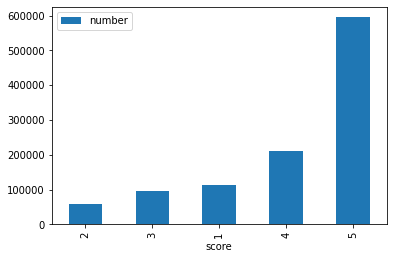

In [14]:
count = count.toPandas()
count.plot(kind='bar',x='score',y='number')

#### Show First 10 Products with The Most Reviews

In [15]:
product_review_number = spark.sql("SELECT asin as product, count(reviewText) as number FROM data GROUP BY asin ORDER BY number DESC LIMIT 10")
product_review_number.show()

+----------+------+
|   product|number|
+----------+------+
|B00DJFIMW6| 16221|
|B00BGA9WK2|  7561|
|B00FAX6XQC|  5713|
|B009KS4XRO|  5489|
|B002VBWIP6|  5190|
|B0055SWM08|  4638|
|B00CSR2J9I|  4510|
|B0015AARJI|  4468|
|B00178630A|  3522|
|B000FKBCX4|  3290|
+----------+------+



### Clean Review Text

In [16]:
import nltk
nltk.download('stopwords')
nltk.download('words')

[nltk_data] Downloading package stopwords to /home/hadoop/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /home/hadoop/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [17]:
# get the list of stopwords from nltk
from nltk.corpus import stopwords

eng_stopwords = stopwords.words('english')
eng_stopwords.append('xxxx')

#### Set up SparkNLP pipeline

In [18]:
from sparknlp.base import Finisher, DocumentAssembler
from sparknlp.annotator import (Tokenizer, Normalizer, 
                                LemmatizerModel, StopWordsCleaner)
from pyspark.ml import Pipeline

In [19]:
documentAssembler = DocumentAssembler() \
    .setInputCol('reviewText') \
    .setOutputCol('document')

tokenizer = Tokenizer() \
    .setInputCols(['document']) \
    .setOutputCol('token')

# note normalizer defaults to changing all words to lowercase.
# Use .setLowercase(False) to maintain input case.
normalizer = Normalizer() \
    .setInputCols(['token']) \
    .setOutputCol('normalized') \
    .setLowercase(True)

# note that lemmatizer needs a dictionary. So I used the pre-trained
# model (note that it defaults to english)
lemmatizer = LemmatizerModel.pretrained() \
    .setInputCols(['normalized']) \
    .setOutputCol('lemma') \

stopwords_cleaner = StopWordsCleaner() \
    .setInputCols(['lemma']) \
    .setOutputCol('clean_lemma') \
    .setCaseSensitive(False) \
    .setStopWords(eng_stopwords)

# finisher converts tokens to human-readable output
finisher = Finisher() \
    .setInputCols(['clean_lemma']) \
    .setCleanAnnotations(False)

lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]


In [20]:
pipeline = Pipeline() \
    .setStages([
        documentAssembler,
        tokenizer,
        normalizer,
        lemmatizer,
        stopwords_cleaner,
        finisher
    ])

In [21]:
data.createOrReplaceTempView("data")
df = spark.sql("SELECT reviewText FROM data")
df.show(10)

+--------------------+
|          reviewText|
+--------------------+
|this is a old cla...|
|This game is more...|
|If you love WWF n...|
|I had WWF Wrestle...|
|I have to admit I...|
|This game was ama...|
|This right here i...|
|The Rampage Editi...|
|Remember the mome...|
|Back in 1993 Sega...|
+--------------------+
only showing top 10 rows



In [22]:
equifax = pipeline.fit(df).transform(df)
temp = equifax.select('finished_clean_lemma')
temp.show(10)

+--------------------+
|finished_clean_lemma|
+--------------------+
|[old, classic, wr...|
|[game, oneonone, ...|
|[love, wwf, call,...|
|[wwf, wrestlemani...|
|[admit, hadnt, st...|
|[game, amazing, b...|
|[right, bit, arca...|
|[rampage, edition...|
|[remember, moment...|
|[back, sega, rele...|
+--------------------+
only showing top 10 rows



In [23]:
from pyspark.sql.functions import monotonically_increasing_id, row_number
from pyspark.sql.window import Window
data=data.withColumn('row_index', row_number().over(Window.orderBy(monotonically_increasing_id())))
temp=temp.withColumn('row_index', row_number().over(Window.orderBy(monotonically_increasing_id())))
data = data.join(temp, on=["row_index"]).drop("row_index")
data.show(10)

+----------+-------+--------------------+--------------------+--------------------+
|      asin|overall|          reviewText|             summary|finished_clean_lemma|
+----------+-------+--------------------+--------------------+--------------------+
|B00002STAU|      5|this is a old cla...|           a classic|[old, classic, wr...|
|B00002STAU|      4|This game is more...|  good fighting game|[game, oneonone, ...|
|B00002STAU|      5|If you love WWF n...|WWF Wrestlemania ...|[love, wwf, call,...|
|B00002STAU|      4|I had WWF Wrestle...|wrestling game wi...|[wwf, wrestlemani...|
|B00002STAU|      4|I have to admit I...|           A Classic|[admit, hadnt, st...|
|B00002STAU|      5|This game was ama...|The Best Wrestlin...|[game, amazing, b...|
|B00002STAU|      4|This right here i...|wrestling at it's...|[right, bit, arca...|
|B00002SVP7|      3|The Rampage Editi...|A few new levels ...|[rampage, edition...|
|B00002SVP7|      2|Remember the mome...|                WTF?|[remember, mom

In [24]:
data.cache()

DataFrame[asin: string, overall: int, reviewText: string, summary: string, finished_clean_lemma: array<string>]

### Split dataset into training set and test set

In [25]:
splitted_data = data.randomSplit([0.8, 0.2])
train_data = splitted_data[0]
test_data = splitted_data[1]

print("Number of training records: " + str(train_data.count()))
print("Number of testing records : " + str(test_data.count()))

Number of training records: 860190
Number of testing records : 215122


### Build Models

#### Import Modeling Packages 

In [38]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, IndexToString, VectorAssembler, CountVectorizer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline, Model

#### Build LogisticRegression model(s) and train them using pipelines

In [73]:
countVectors = CountVectorizer(inputCol="finished_clean_lemma", outputCol="features", vocabSize=10000, minDF=5)
stringIndexer_label = StringIndexer(inputCol="overall", outputCol="label")

In [74]:
logit = LogisticRegression(labelCol="label", featuresCol="features")

In [75]:
labelConverter = IndexToString(inputCol="prediction", 
                               outputCol="predictedLabel", 
                               labels=stringIndexer_label.fit(train_data).labels)

In [76]:
pipeline_logit = Pipeline(stages=[
                               countVectors,
                               stringIndexer_label,
                               logit,
                               labelConverter])

#### Train the model using training set

In [77]:
logit_model= pipeline_logit.fit(train_data)

#### Run the predictions on test data using the trained model

In [78]:
predictions = logit_model.transform(test_data)

In [79]:
predictions.printSchema()

root
 |-- asin: string (nullable = true)
 |-- overall: integer (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- finished_clean_lemma: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- features: vector (nullable = true)
 |-- label: double (nullable = false)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)
 |-- predictedLabel: string (nullable = true)



In [80]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print("Accuracy score is: ", evaluator.evaluate(predictions))

Accuracy score is:  0.5966646543569462


In [19]:
sc.stop()
spark.stop()

### Import Modeling Packages 

In [9]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, IndexToString, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline, Model

### Feature Engineering 

In [17]:
stringIndexer_label = StringIndexer(inputCol="overall", outputCol="label")

In [18]:
stringIndexer_feature = StringIndexer(inputCol="reviewText", outputCol="features")

### Split dataset into training set and test set

In [19]:
splitted_data = data.randomSplit([0.8, 0.2])
train_data = splitted_data[0]
test_data = splitted_data[1]

print("Number of training records: " + str(train_data.count()))
print("Number of testing records : " + str(test_data.count()))

Number of training records: 859944
Number of testing records : 215368


### Build LogisticRegression model(s) and train them using pipelines

In [20]:
logit = LogisticRegression(labelCol="label", featuresCol="features")

In [21]:
labelConverter = IndexToString(inputCol="prediction", 
                               outputCol="predictedLabel", 
                               labels=stringIndexer_label.fit(train_data).labels)

In [22]:
pipeline_logit = Pipeline(stages=[stringIndexer_label,stringIndexer_feature,logit,labelConverter])

### Train the model using training set

In [23]:
logit_model= pipeline_logit.fit(train_data)

IllegalArgumentException: 'requirement failed: Column features must be of type struct<type:tinyint,size:int,indices:array<int>,values:array<double>> but was actually double.'